<a href="https://colab.research.google.com/github/RodrigoRS11/DIO-desafioBairesdev-detecFacial/blob/main/DIO_bairesdevDesafio_detecFacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DIO-bairesdevDesafio-detecFacial**

O objetivo principal deste projeto é aplicar as bibliotecas e frameworks estudados ao longo das aulas, com foco no desenvolvimento de um sistema de detecção e reconhecimento de faces. Utilizando o framework TensorFlow em conjunto com as bibliotecas que forem consideradas adequadas pelo projetista, a proposta visa explorar as capacidades do aprendizado de máquina para identificar e classificar faces em imagens de forma eficaz.

Detecção de Faces: Para a detecção, será utilizada uma rede neural treinada para localizar as faces na imagem. Isso pode ser feito por meio de redes como o MTCNN (Multi-task Cascaded Convolutional Networks), que é amplamente utilizada para a detecção de faces em tempo real ou imagens.

Classificação das Faces Detectadas: A rede de detecção foi utilizada para localizar as faces na imagem, e em seguida, as faces detectadas foram submetidas a uma rede de classificação para determinar a identidade da pessoa. Para isso, foi feita um transfer learning no modelo VGG16 com o conjunto de dados específico da tarefa. Esse processo permitiu que o modelo aprendesse as características essenciais para identificar as faces corretamente, mantendo a precisão e a eficiência, sem a necessidade de treinamento completo desde o início.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

In [2]:
# Definições básicas
img_size = (128, 128)  # Tamanho das imagens
batch_size = 32  # Número de imagens processadas por vez
dataset_path = "/content/sample_data/dataset2"  # Caminho para seu dataset

# Data Augmentation (aumenta variedade do dataset artificialmente)
datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza os pixels (0-1)
    rotation_range=20,  # Rotação aleatória
    width_shift_range=0.2,  # Deslocamento horizontal
    height_shift_range=0.2,  # Deslocamento vertical
    shear_range=0.2,  # Inclinação aleatória
    zoom_range=0.2,  # Zoom aleatório
    horizontal_flip=True,  # Espelhamento horizontal
    validation_split=0.2  # 20% dos dados para validação
)

# Carregar os dados de treino
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Carregar os dados de validação
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Mapeia os índices para os nomes das classes
class_names = train_generator.class_indices
print("Classes detectadas:", class_names)

# Carregar o modelo pré-treinado VGG16, sem as camadas finais (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar as camadas do modelo base (não treinar essas camadas)
base_model.trainable = False

Found 36 images belonging to 4 classes.
Found 7 images belonging to 4 classes.
Classes detectadas: {'.ipynb_checkpoints': 0, 'desconhecido': 1, 'julius': 2, 'rochelle': 3}


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
model = Sequential([
    base_model,  # Usando a base do VGG16 como modelo
    Flatten(),  # Achatar a saída do VGG16
    Dense(128, activation='relu'),  # Camada densa adicional
    Dropout(0.5),  # Evita overfitting
    Dense(len(class_names), activation='softmax')  # Camada final de classificação
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir a estrutura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Definir número de épocas
epochs = 50

# Treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3657 - loss: 1.6621 - val_accuracy: 0.4286 - val_loss: 1.0302
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4606 - loss: 1.1041 - val_accuracy: 0.4286 - val_loss: 1.0295
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4815 - loss: 1.5857 - val_accuracy: 0.5714 - val_loss: 1.0457
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3947 - loss: 1.7937 - val_accuracy: 0.4286 - val_loss: 1.0778
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 9s/step - accuracy: 0.5463 - loss: 1.4356 - val_accuracy: 0.7143 - val_loss: 0.9457
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 0.4259 - loss: 1.4010 - val_accuracy: 0.5714 - val_loss: 1.6564
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5579 - loss: 1.0548 - val_accuracy: 0.5714 - val_loss: 1.4858
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 8s/step - accuracy: 0.5370 - loss: 1.2483 - val_accuracy: 0.4286 - val_loss: 1.3116
Epoch 9/50
2

In [6]:
model.save("modelo_reconhecimento.h5")
print("Modelo salvo com sucesso!")


Modelo salvo com sucesso!


In [12]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from mtcnn import MTCNN
from google.colab.patches import cv2_imshow

# Carregar o modelo treinado
model = tf.keras.models.load_model("modelo_reconhecimento.h5")

class_dict = {0: ".ipynb_checkpoints", 1: "desconhecido", 2: "julius", 3: "rochelle"}

# Verificar as camadas do modelo
print("Camadas do modelo:")
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.output.shape}")

# Se o modelo foi treinado com flow_from_directory(), tente acessar as classes:
try:
    class_names = model.class_indices
    print("Classes do modelo:", class_names)
except AttributeError:
    print("As classes não estão armazenadas diretamente no modelo.")

# Carregar uma nova imagem para teste
image_path = "/content/sample_data/dataset2/julius/7.jpg"
image = load_img(image_path, target_size=(128, 128))  # Redimensiona
image_array = img_to_array(image) / 255.0  # Normaliza
image_array = np.expand_dims(image_array, axis=0)  # Adiciona batch dimension

# Fazer previsão
prediction = model.predict(image_array)
class_index = np.argmax(prediction)
person_name = list(class_names.keys())[list(class_names.values()).index(class_index)]

print("Classes detectadas:", class_names)

print(f"Identificado como: {person_name}")

Camadas do modelo:
0: vgg16 - (None, 4, 4, 512)
1: flatten - (None, 8192)
2: dense - (None, 128)
3: dropout - (None, 128)
4: dense_1 - (None, 4)
As classes não estão armazenadas diretamente no modelo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Classes detectadas: {'.ipynb_checkpoints': 0, 'desconhecido': 1, 'julius': 2, 'rochelle': 3}
Identificado como: julius


In [8]:
pip install MTCNN

In [9]:
pip install LZ4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Predição: desconhecido - Confiança: 0.99
Identificado como: desconhecido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predição: rochelle - Confiança: 0.42
Identificado como: rochelle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Predição: julius - Confiança: 0.93
Identificado como: julius
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predição: desconhecido - Confiança: 0.99
Identificado como: desconhecido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predição: desconhecido - Confiança: 0.98
Identificado como: desconhecido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predição: desconhecido - Confiança: 0.59
Identificado como: desconhecido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Predição: desconhecido - Confiança: 0.72
Identificado como: desconhecido


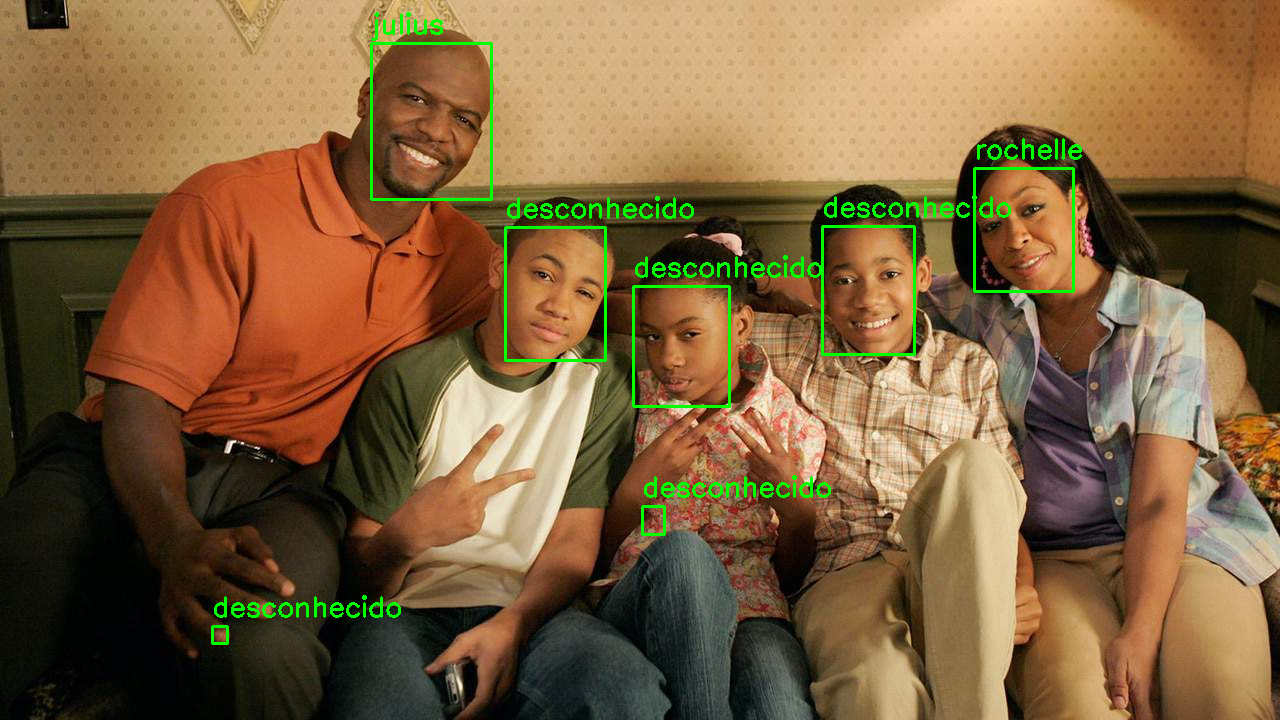

In [13]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow  # Necessário para Colab

# Carregar o modelo treinado
model = tf.keras.models.load_model("modelo_reconhecimento.h5")

# Dicionário de classes
class_dict = {0: ".ipynb_checkpoints", 1: "desconhecido", 2: "julius", 3: "rochelle"}

# Inicializa o detector MTCNN
detector = MTCNN()

# Função para pré-processar uma face antes da predição
def preprocess_face(face):
    face = cv2.resize(face, (128, 128))  # Ajusta para o tamanho do modelo
    face = img_to_array(face) / 255.0  # Normaliza os pixels
    face = np.expand_dims(face, axis=0)  # Adiciona dimensão de batch
    return face

# Carregar a imagem de teste
image_path = "/content/sample_data/todo-mundo-odeia-o-chris.jpg"  # Caminho da imagem
image = cv2.imread(image_path)

# Verificar se a imagem foi carregada corretamente
if image is None:
    print("Erro: Não foi possível carregar a imagem. Verifique o caminho!")
    exit()

# Converter para RGB (MTCNN requer esse formato)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detectar faces na imagem
faces = detector.detect_faces(rgb_image)

# Se nenhuma face for detectada
if len(faces) == 0:
    print("Nenhuma face detectada na imagem.")
    exit()

# Processar cada face detectada
for face in faces:
    x, y, w, h = face['box']

    # Extrair a região da face
    face_crop = image[y:y+h, x:x+w]

    if face_crop.shape[0] > 0 and face_crop.shape[1] > 0:
        # Pré-processar a face
        processed_face = preprocess_face(face_crop)

        # Fazer a predição
        prediction = model.predict(processed_face)
        class_index = np.argmax(prediction)
        person_name = class_dict.get(class_index, "Desconhecido")  # Obtém o nome correto

        # Exibir informações da predição
        print(f"Predição: {person_name} - Confiança: {prediction[0][class_index]:.2f}")
        print(f"Identificado como: {person_name}")

        # Desenhar a caixa e o nome na imagem
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, person_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Exibir a imagem final com as detecções
cv2_imshow(image)


# **Resultado**
O objetivo deste projeto era identificar os rostos dos membros da família da série Todo Mundo Odeia o Chris, com foco em reconhecer exclusivamente os pais como autorizados pelo sistema. A ideia seria aplicar esse reconhecimento em um sistema de segurança, como o controle de acesso a um cofre ou outro local privado. No entanto, se o sistema fosse destinado a um cofre, é provável que o Julius preferisse ser o único com acesso